[Article](https://arxiv.org/pdf/1909.05820.pdf)

[Qiskit](https://qiskit.org/textbook/ch-paper-implementations/vqls.html)

In [1]:
!pip install qiskit

Defaulting to user installation because normal site-packages is not writeable


In [417]:
from collections import defaultdict
logs = defaultdict(lambda: defaultdict(list))

In [571]:
logs[3]

defaultdict(list, {})

In [572]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize
from itertools import groupby

In [573]:
N = 3
n_qubits = range(1, N+1)
n0_qubits = range(0, N)

In [574]:
pauli_mats = {
    0: np.array([
        [1, 0], 
        [0, 1]]),
    1: np.array([
        [0, 1], 
        [1, 0]]),
    2: np.array([
        [0, -1j], 
        [1j, 0]]),
    3: np.array([
        [1, 0], 
        [0, -1]]),}

def pauli_gate_to_mat(gate):
    res = np.array([[1]])
    
    for pauli_type in (gate):
#         print(np.tensordot(res, pauli_mats[pauli_type], axes=0).shape)
        res = np.transpose(np.tensordot(res, pauli_mats[pauli_type], axes=0), [1, 2, 0, 3]).reshape(len(res)*2, len(res)*2)
        
    return res
    

def gate_sets_to_mat(gate_set, coefficient_set):
    matrix_size = len(gate_set[0])
    res = np.zeros((2**matrix_size, 2**matrix_size))
    
    for gate, coeff in (list(zip(gate_set, coefficient_set))):
        res += pauli_gate_to_mat(gate) * coeff
        
    return res

available_paulis = [1]

def generator_mat2():
    coefficient_set = []
    I = [0 for _ in range(N)]
    gate_set = []
    
    for j in range(N):
        for k in range(N):
            if j == k:
                continue
                
            if np.random.rand() < 0.5:
                continue
            
            ajk = np.random.rand() * 2 - 1 # [-1, 1]
            
            alpha, beta = np.random.choice(available_paulis, 2)
            
            gate = I.copy()
            gate[j] = alpha
            gate[k] = alpha
            
            coefficient_set.append(ajk)
            gate_set.append(gate)
            
            
            
            
    return coefficient_set, gate_set
    
    
coefficient_set, gate_set = generator_mat2() 

gate_sets_to_mat(gate_set, coefficient_set)


array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.5589028, 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.5589028],
       [0.       , 0.       , 0.       , 0.       , 0.5589028, 0.       ,
        0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.5589028,
        0.       , 0.       ],
       [0.       , 0.       , 0.5589028, 0.       , 0.       , 0.       ,
        0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.5589028, 0.       , 0.       ,
        0.       , 0.       ],
       [0.5589028, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       ],
       [0.       , 0.5589028, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       ]])

In [575]:
import math

class MatrixGenerator:
    def generate():
        raise NotImplementedError
        
class Ansatz:
    
    parameters_shape = 0
    
    def get_paramenters_size(self):
        return math.prod(self.parameters_shape)
    
    def reshape_parameters(self, parameters):
        return np.reshape(parameters, self.parameters_shape)
    
    def generate(self, parameters):
        out_f = self.reshape_parameters(parameters)

        circ = QuantumCircuit(N, N)
        self.apply(circ, n0_qubits, out_f)
        circ.save_statevector()

        backend = Aer.get_backend('aer_simulator')

        t_circ = transpile(circ, backend)
        qobj = assemble(t_circ)
        job = backend.run(qobj)

        result = job.result()
        o = result.get_statevector(circ, decimals=10)
        
        return o
    
    def apply(self, qubits, parameters):
        raise NotImplementedError
        
    def apply_control(self, qubits, parameters, auxiliary, reg):
        raise NotImplementedError
    
class CostFunction:
    def __init__(self, ansatz, gate_set, coefficient_set, circ):
        self.ansatz = ansatz
        self.gate_set = gate_set
        self.coefficient_set = coefficient_set
        self.circ = circ
        
    def had_test(self, circ, gate_type, qubits, auxiliary_index, parameters):

        circ.h(auxiliary_index)

        self.ansatz.apply(circ, qubits, parameters)

        for ie in range (0, len(gate_type[0])):
            if (gate_type[0][ie] == 1):
                circ.cx(auxiliary_index, qubits[ie])
            elif (gate_type[0][ie] == 2):
                circ.cy(auxiliary_index, qubits[ie])
            elif (gate_type[0][ie] == 3):
                circ.cz(auxiliary_index, qubits[ie])

        for ie in range (0, len(gate_type[1])):
            if (gate_type[1][ie] == 1):
                circ.cx(auxiliary_index, qubits[ie])
            elif (gate_type[1][ie] == 2):
                circ.cy(auxiliary_index, qubits[ie])
            elif (gate_type[1][ie] == 3):
                circ.cz(auxiliary_index, qubits[ie])

        circ.h(auxiliary_index)
        
    def special_had_test(self, circ, control_b, gate_type, qubits, auxiliary_index, parameters, reg):

        circ.h(auxiliary_index)

        self.ansatz.apply_control(circ, qubits, parameters, auxiliary_index, reg)

        for ty in range (0, len(gate_type)):
            if (gate_type[ty] == 1):
                circ.cx(auxiliary_index, qubits[ty])
            elif (gate_type[ty] == 2):
                circ.cy(auxiliary_index, qubits[ty])
            elif (gate_type[ty] == 3):
                circ.cz(auxiliary_index, qubits[ty])

        # U|0) = b
        control_b(circ, auxiliary_index, qubits)

        circ.h(auxiliary_index)
        
    def calculate(parameters):
        raise NotImplementedError

In [576]:
class AnsatzRY(Ansatz):
    
    parameters_shape = (N, N)
    
    def apply(self, circ, qubits, parameters):
        for iz in range (0, N):
            circ.ry(parameters[0][iz], qubits[iz])

        circ.cz(qubits[0], qubits[1])
#         circ.cz(qubits[2], qubits[0])

        for iz in range (0, N):
            circ.ry(parameters[1][iz], qubits[iz])

        circ.cz(qubits[1], qubits[2])
#         circ.cz(qubits[2], qubits[0])

        for iz in range (0, N):
            circ.ry(parameters[2][iz], qubits[iz])
            
            
    def apply_control(self, circ, qubits, parameters, auxiliary, reg):
        for i in range (0, N):
            circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

        circ.ccx(auxiliary, qubits[1], N+1)
        circ.cz(qubits[0], N+1)
        circ.ccx(auxiliary, qubits[1], N+1)

#         circ.ccx(auxiliary, qubits[0], N+1)
#         circ.cz(qubits[2], N+1)
#         circ.ccx(auxiliary, qubits[0], N+1)

        for i in range (0, N):
            circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

        circ.ccx(auxiliary, qubits[2], N+1)
        circ.cz(qubits[1], N+1)
        circ.ccx(auxiliary, qubits[2], N+1)

#         circ.ccx(auxiliary, qubits[0], N+1)
#         circ.cz(qubits[2], N+1)
#         circ.ccx(auxiliary, qubits[0], N+1)

        for i in range (0, len(qubits)):
            circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

In [577]:
class AnsatzHERY(Ansatz):
    
    parameters_shape = (N, N)
    
    def apply(self, circ, qubits, parameters):
        
        layer_count = self.parameters_shape[0]
        
        for layer in range(0, layer_count):
            
            for i in range (0, N):
                circ.ry(parameters[layer][i], qubits[i])
              
            if layer != layer_count-1:
                for iz in range (layer % 2, N-1, 2):
                    circ.cz(qubits[iz], qubits[iz+1])
        
            
            
    def apply_control(self, circ, qubits, parameters, auxiliary, reg):
        
        layer_count = self.parameters_shape[0]
        
        for layer in range(0, layer_count):
            
            for i in range (0, len(qubits)):
                circ.cry(parameters[layer][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

            if layer != layer_count-1:
                for iz in range (layer % 2, N-1, 2):
                    circ.ccx(auxiliary, qubits[iz+1], N+1)
                    circ.cz(qubits[iz], N+1)
                    circ.ccx(auxiliary, qubits[iz+1], N+1)



In [578]:
# (N, iteration, cost)  


In [579]:
# Implements the entire cost function on the quantum circuit

iteration_number = 0

class MyCostFunction(CostFunction):
    
    def cost_calculate(self, parameters, print_logs=True):

        global opt

        overall_sum_1 = 0

        new_parameters = self.ansatz.reshape_parameters(parameters)

        for i in range(0, len(self.gate_set)):
            for j in range(0, len(self.gate_set)):

                qctl = QuantumRegister(N+2)
                qc = ClassicalRegister(N+2)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                multiply = self.coefficient_set[i]*self.coefficient_set[j]

                self.had_test(circ, [self.gate_set[i], self.gate_set[j]], n_qubits, 0, new_parameters)

                circ.save_statevector()
                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ)
                job = backend.run(qobj)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n

                overall_sum_1+=multiply*(1-(2*m_sum))

        overall_sum_2 = 0

        for i in range(0, len(self.gate_set)):
            for j in range(0, len(self.gate_set)):

                multiply = self.coefficient_set[i]*self.coefficient_set[j]
                mult = 1

                for extra in range(0, 2):

                    qctl = QuantumRegister(N+2)
                    qc = ClassicalRegister(N+2)
                    circ = QuantumCircuit(qctl, qc)

                    backend = Aer.get_backend('aer_simulator')

                    if (extra == 0):
                        self.special_had_test(circ, control_b, self.gate_set[i], n_qubits, 0, new_parameters, qctl)
                    if (extra == 1):
                        self.special_had_test(circ, control_b, self.gate_set[j], n_qubits, 0, new_parameters, qctl)

                    circ.save_statevector()    
                    t_circ = transpile(circ, backend)
                    qobj = assemble(t_circ)
                    job = backend.run(qobj)

                    result = job.result()
                    outputstate = np.real(result.get_statevector(circ, decimals=100))
                    o = outputstate

                    m_sum = 0
                    for l in range (0, len(o)):
                        if (l%2 == 1):
                            n = o[l]**2
                            m_sum+=n
                    mult = mult*(1-(2*m_sum))

                overall_sum_2+=multiply*mult

        cost = 1 - float(overall_sum_2/overall_sum_1)
        
        global iteration_number
        
        if iteration_number % 10 == 0:
            result = self.ansatz.generate(parameters)
            
            Phi = A @ result.data
            
            if Phi[0] < 0:
                Phi *= -1;
            
            nrm = np.linalg.norm(Phi)
            
            Phi2 = Phi / (Phi @ Phi)**0.5

            diff = np.linalg.norm(Phi2 - b)
            
            mat_cost1 = Phi.reshape(1, -1) @ Hp @ Phi
            
            mat_cost2 = 1 - abs(b @ Phi2)**2 / (Phi @ Phi2)
            
            print('cost:', (mat_cost1, mat_cost2), '\ndata:', np.real(result.data), '\ndiff:', np.real(diff), '\nPhi:', np.real(Phi), '\nPhi2:', np.real(Phi2))
            
            #np.real(result.data.reshape(1, -1) @ Hp @ result.data)[0]

            global logs

            logs[N][iteration_number].append(diff)
        
        
        if print_logs:
            print(cost)
            
        iteration_number += 1

        return cost


In [580]:
class VQLS:
    
    def __init__(self, ansatz, cost_function, optimizer="COBYLA", maxiter = 200):
        self.ansatz = ansatz
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.maxiter = maxiter
        
    
    def calc_cost(self, gate_set, coefficient_set):
        circ = QuantumCircuit(N, N)
        return self.cost_function(self.ansatz, gate_set, coefficient_set, circ).cost_calculate(parameters)
        
        
    def predict(self, gate_set, coefficient_set, print_logs=True):
        circ = QuantumCircuit(N, N)
        global iteration_number
        iteration_number = 0
        def calc_cost_function(parameters):
            return self.cost_function(self.ansatz, gate_set, coefficient_set, circ).cost_calculate(parameters, print_logs) # (parameters -> float)
        start_parameters = [float(random.randint(0,3000))/1000 for i in range(0, self.ansatz.get_paramenters_size())]
        out = minimize(calc_cost_function, x0=start_parameters, method="COBYLA", options={'maxiter': self.maxiter})
        if print_logs:
            print(out)

        out_f = self.ansatz.reshape_parameters(out['x'])

        circ = QuantumCircuit(N, N)
        self.ansatz.apply(circ, n0_qubits, out_f)
        circ.save_statevector()

        backend = Aer.get_backend('aer_simulator')

        t_circ = transpile(circ, backend)
        qobj = assemble(t_circ)
        job = backend.run(qobj)

        result = job.result()
        o = result.get_statevector(circ, decimals=10)
        
        return o, out_f
        
        

In [581]:
vqls = VQLS(AnsatzHERY(), MyCostFunction)

In [582]:
def control_b(circ, auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)
        


circ = QuantumCircuit(N+1)
control_b(circ, 0, n_qubits)
circ.draw()

b = (np.ones(2**N) / 2**N) ** 0.5

Hp = np.eye(2**N) - b.reshape(-1, 1) @ b.reshape(1, -1)

circ.draw()

q_0: ──■────■────■──
     ┌─┴─┐  │    │  
q_1: ┤ H ├──┼────┼──
     └───┘┌─┴─┐  │  
q_2: ─────┤ H ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ H ├
               └───┘

In [583]:
print(b)

[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [584]:
# gate_set = [[0, 1, 0], [0, 0, 0]]

# coefficient_set = [0.5, 0.5]

# coefficient_set = [0.55, 0.45]
# gate_set = [ [0, 0, 0], [0, 1, 0] ]

# coefficient_set = [0.55, 0.225, 0.225]
# gate_set = [ [0, 0, 0], [0, 1, 0], [0, 0, 1] ]

coefficient_set = [0.17, 0.83]
gate_set = [ [1, 0, 0, 0, 0], [0, 1, 1, 1, 1] ]

coefficient_set, gate_set = generator_mat2()

# coefficient_set = [1]
# gate_set = [ [0, 1, 0] ]

for i in range(len(gate_set)):
    gate_set[i] = gate_set[i][0:N]

A = gate_sets_to_mat(gate_set, coefficient_set)

result, parameters = vqls.predict(gate_set, coefficient_set)

np.linalg.norm(A @ result.data - b)

cost: (array([2.46742508+0.j]), (0.984432253149556+0j)) 
data: [-0.02405999 -0.19747127  0.08719266 -0.53692871  0.23674882  0.70230198
 -0.10787388  0.32189496] 
diff: 1.5214208454215798 
Phi: [ 0.91359097 -0.23117055  0.1781585  -0.46073897 -0.48979131  0.46266399
 -0.96465151 -0.11601998] 
Phi2: [ 0.57436112 -0.1453335   0.11200561 -0.28965977 -0.30792454  0.29087
 -0.60646213 -0.07294005]
0.9722879207503737
0.9817743546445789
0.9049739620573036
0.8777292946692518
0.8564999471198247
0.6521329312374662
0.3867896580071225
0.6611942010284969
0.28038006860044784
0.47117167297449125
cost: (array([0.85457145+0.j]), (0.6043593486397906+0j)) 
data: [-0.06737946  0.56392582  0.27994248  0.71206645 -0.0432476   0.09384465
  0.12598109  0.25591571] 
diff: 0.7298902053443738 
Phi: [ 0.86829581  0.50057674  0.5364681  -0.05758935  0.29172768  0.62615047
 -0.16655047  0.22369164] 
Phi2: [ 0.63828447  0.36797409  0.39435783 -0.04233394  0.21444909  0.46028337
 -0.12243129  0.16443578]
0.4765054426

0.0006583150884209577
0.0006580520996196659
0.0006571626794777963
0.0006611968701871751
cost: (array([0.02020185+0.j]), (0.31917827917458996+0j)) 
data: [0.34357323 0.4394381  0.43750825 0.34183956 0.268464   0.34378483
 0.34392718 0.26839713] 
diff: 0.09781702203522744 
Phi: [0.50301296 0.58848046 0.59076057 0.504865   0.44812281 0.50413017
 0.50564787 0.45007089] 
Phi2: [0.34576255 0.40451146 0.40607876 0.34703561 0.30803199 0.3465305
 0.34757374 0.30937107]
0.0006548480244655819
0.0006840228765263578
0.0006606130230774054
0.0006362480449003671
0.0006563761093607567
0.0006371554586875883
0.0006216546996208328
0.0006151594370484847
0.0006145708068104883
0.0006106964404914983
cost: (array([0.01896026+0.j]), (0.31918789367012657+0j)) 
data: [0.34376127 0.43632839 0.43554648 0.34228553 0.27180705 0.34497154
 0.3442418  0.27055267] 
diff: 0.09469787060621217 
Phi: [0.5033434  0.58653668 0.58865058 0.50574502 0.45033849 0.5047183
 0.50698696 0.45253658] 
Phi2: [0.34577614 0.40292649 0.4043

0.4695049216748361

In [ ]:
qctl = QuantumRegister(N+2)
qc = ClassicalRegister(N+2)
circ = QuantumCircuit(qctl, qc)
AnsatzHERY().apply_control(circ, n_qubits, parameters, 0, qctl)
circ.draw()


In [ ]:
np.real(A @ result.data), b

In [391]:
np.real(result.data)

array([-0.39279222, -0.45111409, -0.29384237, -0.23974387, -0.28861469,
       -0.23895294, -0.39703749, -0.44760939])

In [392]:
np.linalg.norm(A @ result.data + b)

0.1253876870250303

In [393]:
np.linalg.norm(A @ result.data - b)

1.9759542237556948

In [486]:
A = gate_sets_to_mat(gate_set, coefficient_set)

A[1]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.83, 0.  , 0.  , 0.17, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [229]:
Phi = A @ result.data

In [230]:
Phi / np.linalg.norm(Phi)

array([ 0.99728732+0.j, -0.02136135+0.j,  0.00231661+0.j, -0.05781716+0.j,
       -0.03740073+0.j, -0.00184239+0.j,  0.01413465+0.j,  0.00339159+0.j])

In [231]:
(b @ Phi / np.linalg.norm(Phi))**2

(0.012619954060687794+0j)

In [208]:
np.real(result.data)

array([ 0.97254438, -0.14172628,  0.00131669,  0.15267998, -0.06364412,
       -0.0035053 , -0.08147173, -0.00759445])

In [209]:
# Phi Hp Phi
Phi.reshape(1, -1) @ Hp @ Phi

array([0.93242298+0.j])

In [210]:
Phi2 = A @ result.data / (A @ result.data @ A @ result.data)**0.5

In [211]:
# 1 - |b Phi|^2 / PhiPhi
1 - abs(b @ Phi)**2 / (Phi @ Phi)

(0.9851739943670488+0j)

In [212]:
Phi

array([ 0.97254438+0.j, -0.01417263+0.j, -0.00131669+0.j, -0.015268  +0.j,
       -0.00636441+0.j, -0.0035053 +0.j,  0.00814717+0.j,  0.00759445+0.j])

In [213]:
b

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


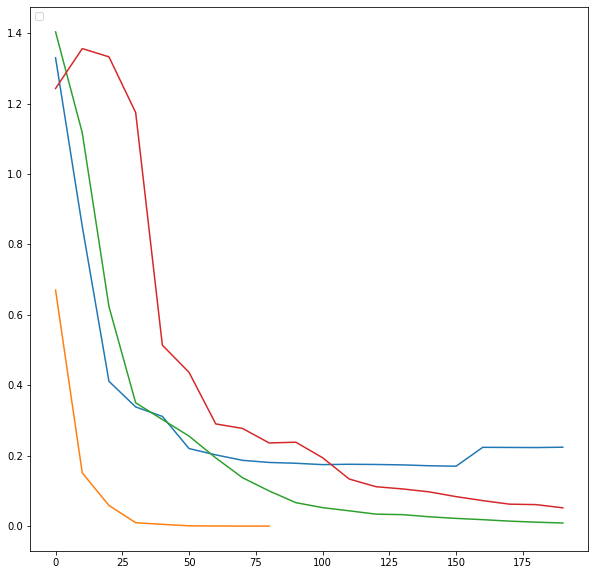

In [545]:
import matplotlib.pyplot as plt

plt.legend(loc = "upper left")

for i in logs:

    xs = []
    ys = []
    for k in logs[i]:
        xs.append(k)
        ys.append(np.mean(logs[i][k]))

    plt.plot(xs, ys, label="N = " + str(i))
    
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


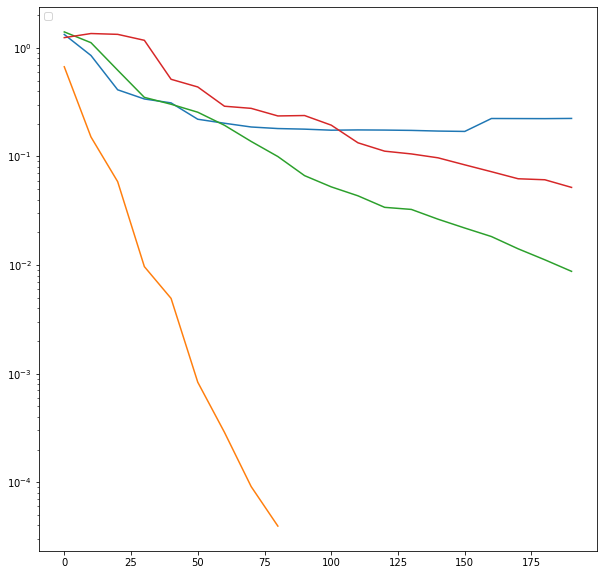

In [546]:
import matplotlib.pyplot as plt

plt.legend(loc = "upper left")

plt.yscale('log')

for i in logs:

    xs = []
    ys = []
    for k in logs[i]:
        xs.append(k)
        ys.append(np.mean(logs[i][k]))

    plt.plot(xs, ys, label="N = " + str(i))
    
plt.show()

In [521]:
from tqdm import tqdm

coefficient_set = [0.55, 0.45]
gate_set = [ [0, 0, 0, 0], [0, 1, 0, 0] ]

for i in range(len(gate_set)):
    gate_set[i] = gate_set[i][0:N]
        
for i in tqdm(range(10)):
    result, parameters = vqls.predict(gate_set, coefficient_set, print_logs=False)

 10%|████▎                                      | 1/10 [01:49<16:26, 109.56s/it]capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.



KeyboardInterrupt: 

In [10]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ])
circ.draw()

┌───────┐      ┌───────┐      ┌───────┐
q_0: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├
     ├───────┤ │  │ ├───────┤    │ ├───────┤
q_1: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├
     ├───────┤    │ ├───────┤ │  │ ├───────┤
q_2: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├
     └───────┘      └───────┘      └───────┘

In [11]:
# Creates the Hadamard test

def had_test(gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([ [0, 0, 0], [0, 0, 1] ], [1, 2, 3], 0, [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ])
circ.draw()

┌───┐                                   ┌───┐
q_0: ──┤ H ├─────────────────────────────────■─┤ H ├
     ┌─┴───┴─┐      ┌───────┐      ┌───────┐ │ └───┘
q_1: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├─┼──────
     ├───────┤ │  │ ├───────┤    │ ├───────┤ │      
q_2: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├─┼──────
     ├───────┤    │ ├───────┤ │  │ ├───────┤ │      
q_3: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├─■──────
     └───────┘      └───────┘      └───────┘

In [13]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ], 0, q_reg)
circ.draw()

»
q18_0: ────■────────■────────■──────■───────■────■───────■──────■────────■────»
       ┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐    │    »
q18_1: ┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├────┼────»
       └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘┌───┴───┐»
q18_2: ─────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────┤ Ry(1) ├»
                └───────┘┌───┴───┐  │   │   │    │       │           └───────┘»
q18_3: ──────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼────────────────────»
                         └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  »
q18_4: ───────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────────────────»
                                  └───┘   └───┘└───┘   └───┘                  »
«                                                                     
«q18_0: ────■──────■───────■────■───────■──────■────────■────────■────
«           │      │       │    │       │  ┌───┴───┐    │        │    
«q18_1: ────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────
«           │      │       │    │       │  └───────┘┌───┴───┐    │    
«q18_2: ────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────
«       ┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐
«q18_3: ┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├
«       └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘
«q18_4: ─────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────
«                └───┘   └───┘└───┘   └───┘

In [14]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw()

q_0: ──■────■────■──
     ┌─┴─┐  │    │  
q_1: ┤ H ├──┼────┼──
     └───┘┌─┴─┐  │  
q_2: ─────┤ H ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ H ├
               └───┘

In [15]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test([ [0, 0, 0], [0, 0, 1] ], [1, 2, 3], 0, [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ], q_reg)
circ.draw()

┌───┐                                                              »
q19_0: ┤ H ├────■────────■────────■──────■───────■────■───────■──────■────»
       └───┘┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐»
q19_1: ─────┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├»
            └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘»
q19_2: ──────────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────»
                     └───────┘┌───┴───┐  │   │   │    │       │           »
q19_3: ───────────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼───────────»
                              └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐         »
q19_4: ────────────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├─────────»
                                       └───┘   └───┘└───┘   └───┘         »
«                                                                              »
«q19_0: ────■────────■──────■───────■────■───────■──────■────────■────────■────»
«           │        │      │       │    │       │  ┌───┴───┐    │        │    »
«q19_1: ────┼────────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────»
«       ┌───┴───┐    │      │       │    │       │  └───────┘┌───┴───┐    │    »
«q19_2: ┤ Ry(1) ├────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────»
«       └───────┘┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐»
«q19_3: ─────────┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├»
«                └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘»
«q19_4: ──────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────»
«                         └───┘   └───┘└───┘   └───┘                           »
«                      ┌───┐
«q19_0: ──■────■────■──┤ H ├
«       ┌─┴─┐  │    │  └───┘
«q19_1: ┤ H ├──┼────┼───────
«       └───┘┌─┴─┐  │       
«q19_2: ─────┤ H ├──┼───────
«            └───┘┌─┴─┐     
«q19_3: ──────────┤ H ├─────
«                 └───┘     
«q19_4: ────────────────────
«

In [16]:
# Implements the entire cost function on the quantum circuit

def calculate_cost_function(parameters):
    
    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9] ]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(5)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('aer_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j] ], [1, 2, 3], 0, parameters)

            circ.save_statevector()
            t_circ = transpile(circ, backend)
            qobj = assemble(t_circ)
            job = backend.run(qobj)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.save_statevector()    
                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ)
                job = backend.run(qobj)

                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [17]:
coefficient_set = [0.55, 0.45]
gate_set = [ [0, 0, 0], [0, 0, 1] ]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9] ]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')
t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[1]*np.array([ [1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1] ])
a2 = coefficient_set[0]*np.array([ [1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1] ])
a3 = np.add(a1, a2)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

0.9650227234975225
0.8628224431139886
0.98125860311319
0.7139898059112642
0.7052166534433495
0.5650926659615199
0.6202113885782531
0.7680558441988488
0.5142917104075904
0.49517732626241673
0.5734734892416187
0.4810443349226424
0.5031491768208822
0.8569638850136914
0.4585856267671229
0.48015925772408996
0.5233497308729975
0.4269649796706184
0.3952568323834217
0.4092017487153904
0.47498828823827066
0.46883076696134274
0.5148423428788607
0.4094837111164292
0.36718932676743254
0.3625537327924323
0.34227566281513966
0.32952161303793004
0.345507814372795
0.3539374792580616
0.34597611209128376
0.3086707949268257
0.30380393301402053
0.2983658808040258
0.32640602530020946
0.28346043842751745
0.3134707020245793
0.31845368908629423
0.23472634682291404
0.13338427893138016
0.10301209796005995
0.44563892599933597
0.17455307226940575
0.13748077280114634
0.15746791736758425
0.22521283832916683
0.12043076308820766
0.10519820629937582
0.16796992008693779
0.12045627906557332
0.16043489955519663
0.1255118